In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import *

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Predicting Weekly Rent using Census, Transportation and Nighttime Lights Data
In this project we will explore how various characteristics of a certain area is associated with median weekly rent prices for the same area. In particular, we will look at the combination of census variables, such as the distribution of age group, educational attainment and income, and spatial datasets, such as transportation points and nighttime lights, to predict median weekly rent per Local Government Area (LGA) of NSW.

The analysis objectives are as follows:
* Create a linear regression model by using the census variables to predict median weekly rent and see if including spatial datasets improve the accuracy of the model.
* Select the best features that give the best prediction for the weekly rent dataset.

The census dataset was extracted from the Census Data Packs of the Australian Bureau of Statistics, the tranportation points were accessed and extracted through the Transport for NSW Open Data API for Public Transport Timetables and the nighttime lights were downloaded from the National Oceanic and Atmospheric Association website. The response variable weekly rent was downloaded from the Department of Communities and Justice (formerly the Department of Family and Community Services). We chose the period of the datasets such that they are closest to the census year, 2016. Below are the specific periods from when the datasets were collected:
* Census (2016)
* Transportation Points (2019)
* Nighttime Lights (2017)
* Weekly Rent (2017)

There were no historical transportation points in the Transport for NSW Open Data API for Public Transport Timetables as they are updated in real-time.

## Weekly Rent
In this section we explore how various characteristics of an LGA are associated with median weekly rent prices. We load the final dataset containing the combined census, transportation, nighttime lights, house sales and weekly rent data.

The weekly rent dataset contains the overall median weekly rent, median weekly rent by bedroom number and weekly median rent by dwelling type. We conduct the analysis by creating a model for each of the three set of data for median weekly rent. For easier data manipulation and transformation, we also rename some of the variables.

In [2]:
final_df = pd.read_csv('../Data/final17_dataset.csv')
col_rename = {'Age_below_15_yr_pct':'pct_age_14below', 'Age_15_64_yr_pct' : 'pct_age_15_64',
              'Age_over_65_yr_pct' : 'pct_age_65above', 'BP_Aus_Perc' : 'pct_birthplace_au',
              'BP_Non_Aus_Perc' : 'pct_birthplace_non_au', 'SE_Yr10_above_Perc' : 'pct_educ_yr10above',
              'SE_Yr9_below_Perc' : 'pct_educ_yr9below', 'MS_Married_Perc' : 'pct_married',
              'MS_Single_Perc' : 'pct_single', 'Percent_Unem_loyment_P' : 'unemployment_rate',
              'Percnt_LabForc_prticipation_P' : 'lfpr', 'Percnt_Employment_to_populn_P' : 'employment_rate', 
              'Median_age_persons' : 'median_age', 'Median_tot_prsnl_inc_weekly' : 'median_weekly_pincome',
              'Median_tot_fam_inc_weekly' : 'median_weekly_fincome',
              'Median_tot_hhd_inc_weekly' : 'median_weekly_hincome', 'Average_household_size' : 'ave_hhsize'}
#final_df = final_df.rename(columns = col_rename)
#final_df.head()

We create new variables for transportation and nighttime lights. We want to create information on how many bus stop there are relative to the land area of the LGA. Similarly, we also want to know how many train stations there are and what is the average nighttime lights relative to the land area for a given LGA.

In [3]:
final_df['ntl17_mean_per_land_area'] = final_df.ntl17_sum / final_df.land_area
final_df['bstop_per_land_area'] = final_df.bus_stop / final_df.land_area
final_df['tstation_per_land_area'] = final_df.train_station / final_df.land_area
final_df['transpo_per_land_area'] = final_df.all_transpo / final_df.land_area

We create separate lists for each set of related variables to access them by descriptive names. We fill the null values with 0 and create the final rent dataset containing these variables. We will use this final dataset for the different instances of our response variable.

In [4]:
lga_id = ['LGA_CODE', 'LGA_NAME']
y_cols = ['r_one_br', 'r_two_br', 'r_three_br', 'r_four_or_more_br', 'r_bedsitter', 'r_not_specified',
          'r_flat', 'r_house', 'r_other', 'r_townhouse', 'r_weekly_rent_median']
X_ntl = ['land_area', 'ntl17_mean', 'ntl17_mean_per_land_area']
X_transpo = ['bus_stop', 'bstop_per_land_area', 'train_station', 'tstation_per_land_area', 'all_transpo',
             'transpo_per_land_area']
X_census_age = ['pct_age_14below', 'pct_age_15_64', 'pct_age_65above']
X_census_origin = ['pct_birthplace_au', 'pct_birthplace_non_au']
X_census_educ = ['pct_educ_yr10above', 'pct_educ_yr9below']
X_census_marital_stat = ['pct_married', 'pct_single']
X_census_employment = ['unemployment_rate', 'lfpr', 'employment_rate']
X_census_educ_qual = ['pct_pgrad', 'pct_grad_cert_dip', 'pct_bach_deg', 'pct_adv_dip', 'pct_cert_iii_iv',
                      'pct_cert_i_ii', 'pct_others']
X_census_stats = ['median_age', 'median_weekly_pincome', 'median_weekly_fincome', 'median_weekly_hincome',
                  'ave_hhsize']

In [5]:
rent_df = final_df[lga_id + y_cols + X_census_age + X_census_origin + X_census_educ + X_census_marital_stat +
                   X_census_employment + X_census_educ_qual + X_census_stats + X_transpo + X_ntl]
rent_df = rent_df.fillna(0)

### Overall Median Weekly Rent for 2017
We first conduct the analysis and create the model for the overall median weekly rent per LGA. We remove from the dataset any observations that have no weekly rent data.

In [6]:
rent_all = rent_df[rent_df.r_weekly_rent_median > 0]
print('Dimensions of the overall rent dataset: ', rent_all.shape)

Dimensions of the overall rent dataset:  (121, 46)


count    121.000000
mean     363.247934
std      143.642150
min      180.000000
25%      250.000000
50%      320.000000
75%      450.000000
max      749.000000
Name: r_weekly_rent_median, dtype: float64

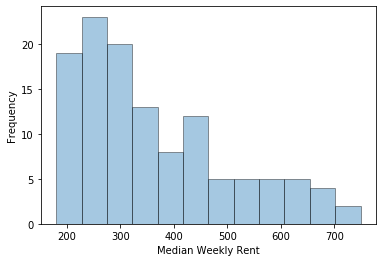

In [7]:
ax = sns.distplot(rent_all.r_weekly_rent_median, bins = 12, kde = False, hist_kws = dict(edgecolor="k"))
ax.set(xlabel = 'Median Weekly Rent', ylabel = 'Frequency')
rent_all.r_weekly_rent_median.describe()

[Text(0.5, 0, 'Median Weekly Rent')]

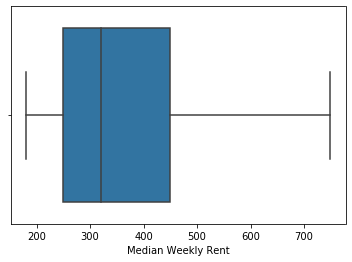

In [8]:
ax = sns.boxplot(rent_all.r_weekly_rent_median)
ax.set(xlabel = 'Median Weekly Rent')

The weekly rent dataset is skewed to the right with most of the data falling between 200 and 300. The average median weekly rent is 363.25 and 50% of the LGAs have median weekly rent of more than 320. The minimum median weekly rent is 180 and the maximum weekly median rent is 749.

#### Relationship of Variables Against Overall Weekly Median Rent
We define a function to create scatterplot and correlation matrix to check the associations between our independent variables and the response variable.

In [9]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha = 0.6, cmap = "coolwarm",
               vmin = -1, vmax = 1, transform = ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords = "axes fraction",
                ha = 'center', va = 'center', fontsize = font_size)
    
def corr_plot(df, cols):
    df_plot = df[cols]
    fig = sns.PairGrid(df_plot)
    fig.map_diag(plt.hist, bins = 12, edgecolor = "black")
    fig.map_lower(plt.scatter, edgecolor = "white")
    fig.map_upper(corrdot)
    return fig

In [10]:
rent_all[X_census_stats].describe()

,median_age,median_weekly_pincome,median_weekly_fincome,median_weekly_hincome,ave_hhsize
count,121.000000,121.000000,121.000000,121.000000,121.000000
mean,41.636364,650.380165,1656.280992,1352.347107,2.501653
std,5.255156,177.348821,538.340973,443.206700,0.256899
min,32.000000,439.000000,1015.000000,767.000000,2.000000
25%,37.000000,540.000000,1328.000000,1052.000000,2.300000
50%,42.000000,600.000000,1474.000000,1197.000000,2.400000
75%,45.000000,682.000000,1817.000000,1509.000000,2.600000
max,54.000000,1386.000000,3671.000000,2687.000000,3.300000


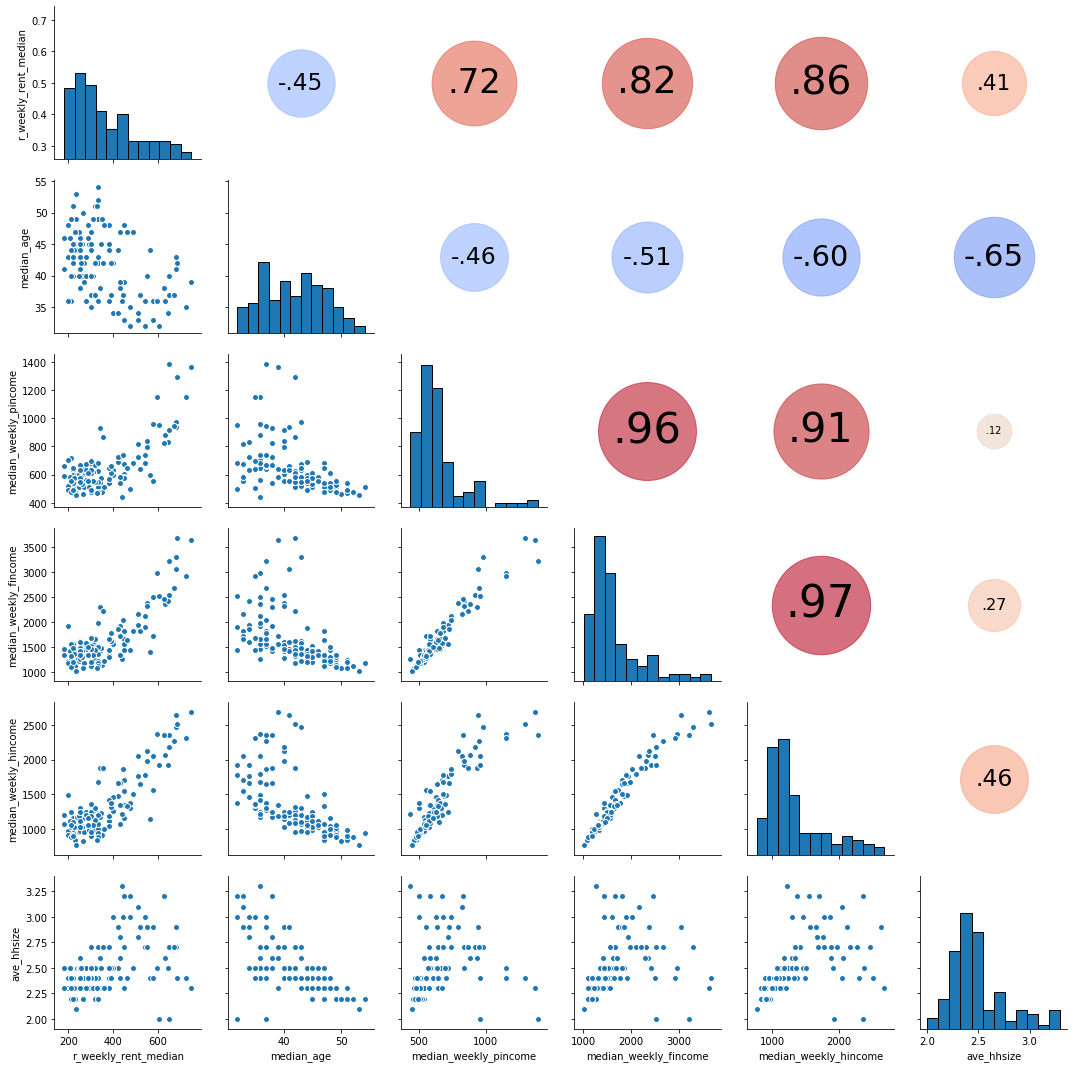

In [11]:
plot_01 = ['r_weekly_rent_median'] + X_census_stats
corr_plot(rent_all, plot_01)

Select census statistics such as the median age, median weekly income and average household size are moderately high to highly correlated against weekly rent. The median age is negatively correlated with weekly rent, which signifies that as weekly rent increases, the median age decreases. This means that LGAs with higher weekly rent generally have a younger population. Weekly income has a very high positive correlation with weekly rent, with the median weekly household income having the highest correlation. This mean that LGAs with higher income levels are typically associated with higher weekly rent. The average household size is only moderately positively correlated with weekly rent. This means that higher weekly rent are associated with LGAs that have bigger families which makes sense since larger families stay on bigger units with more bedrooms.

In [12]:
rent_all[X_census_age + X_census_origin].describe()

,pct_age_14below,pct_age_15_64,pct_age_65above,pct_birthplace_au,pct_birthplace_non_au
count,121.000000,121.000000,121.000000,121.000000,121.000000
mean,18.725238,62.036995,19.237768,82.936437,17.063563
std,2.449690,4.923309,4.991075,15.332267,15.332267
min,6.737852,54.244110,8.212118,39.457759,3.186275
25%,17.092405,58.386580,15.339249,81.122549,6.774823
50%,18.734572,61.063976,19.411705,89.788247,10.211753
75%,20.512902,64.660058,22.517702,93.225177,18.877451
max,23.908319,85.050030,30.561599,96.813725,60.542241


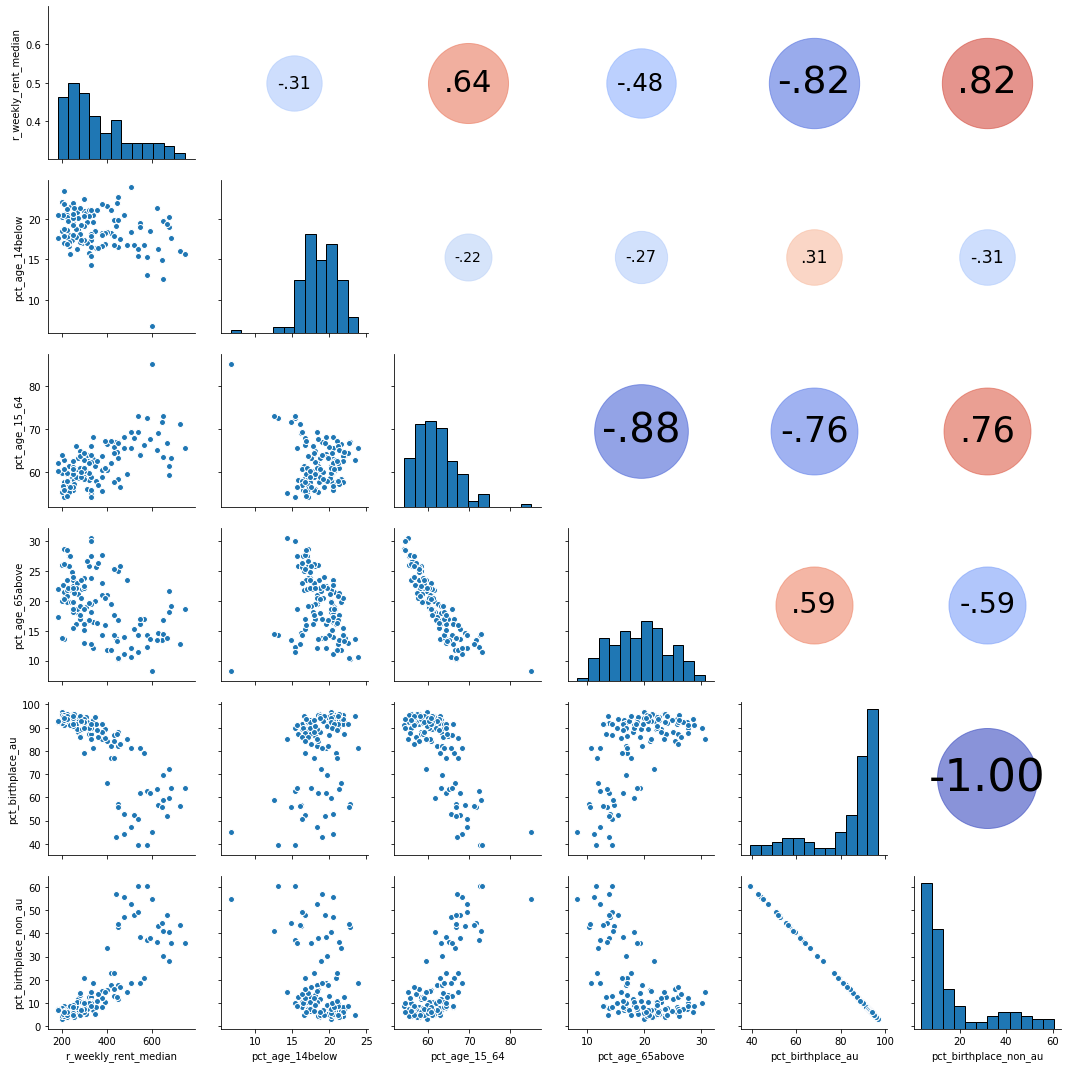

In [13]:
plot_02 = ['r_weekly_rent_median'] + X_census_age + X_census_origin
corr_plot(rent_all, plot_02)

We explore another set of census variables which contain age distribution and birth place. We can see that the 15 to 64 year old cohort has the highest magnitude of correlation. It is also positively correlated which means higher percentages of 15 to 64 year olds in an LGA are typically associated with higher weekly rent. LGAs that have more person born outside of Australia are also associated with higher weekly rent.

In [14]:
rent_all[X_census_educ + X_census_marital_stat + X_census_employment].describe()

,pct_educ_yr10above,pct_educ_yr9below,pct_married,pct_single,unemployment_rate,lfpr,employment_rate
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,84.023622,15.976378,48.875369,51.124631,6.039669,56.600826,53.233884
std,5.369317,5.369317,5.046771,5.046771,1.607404,6.208912,6.372121
min,75.344931,2.718328,25.692379,38.402427,2.900000,42.900000,38.900000
25%,79.971296,13.294401,46.401869,47.996374,4.800000,53.100000,49.500000
50%,82.926588,17.073412,49.294829,50.705171,5.900000,56.000000,53.100000
75%,86.705599,20.028704,52.003626,53.598131,7.300000,60.700000,57.100000
max,97.281672,24.655069,61.597573,74.307621,10.500000,71.000000,68.400000


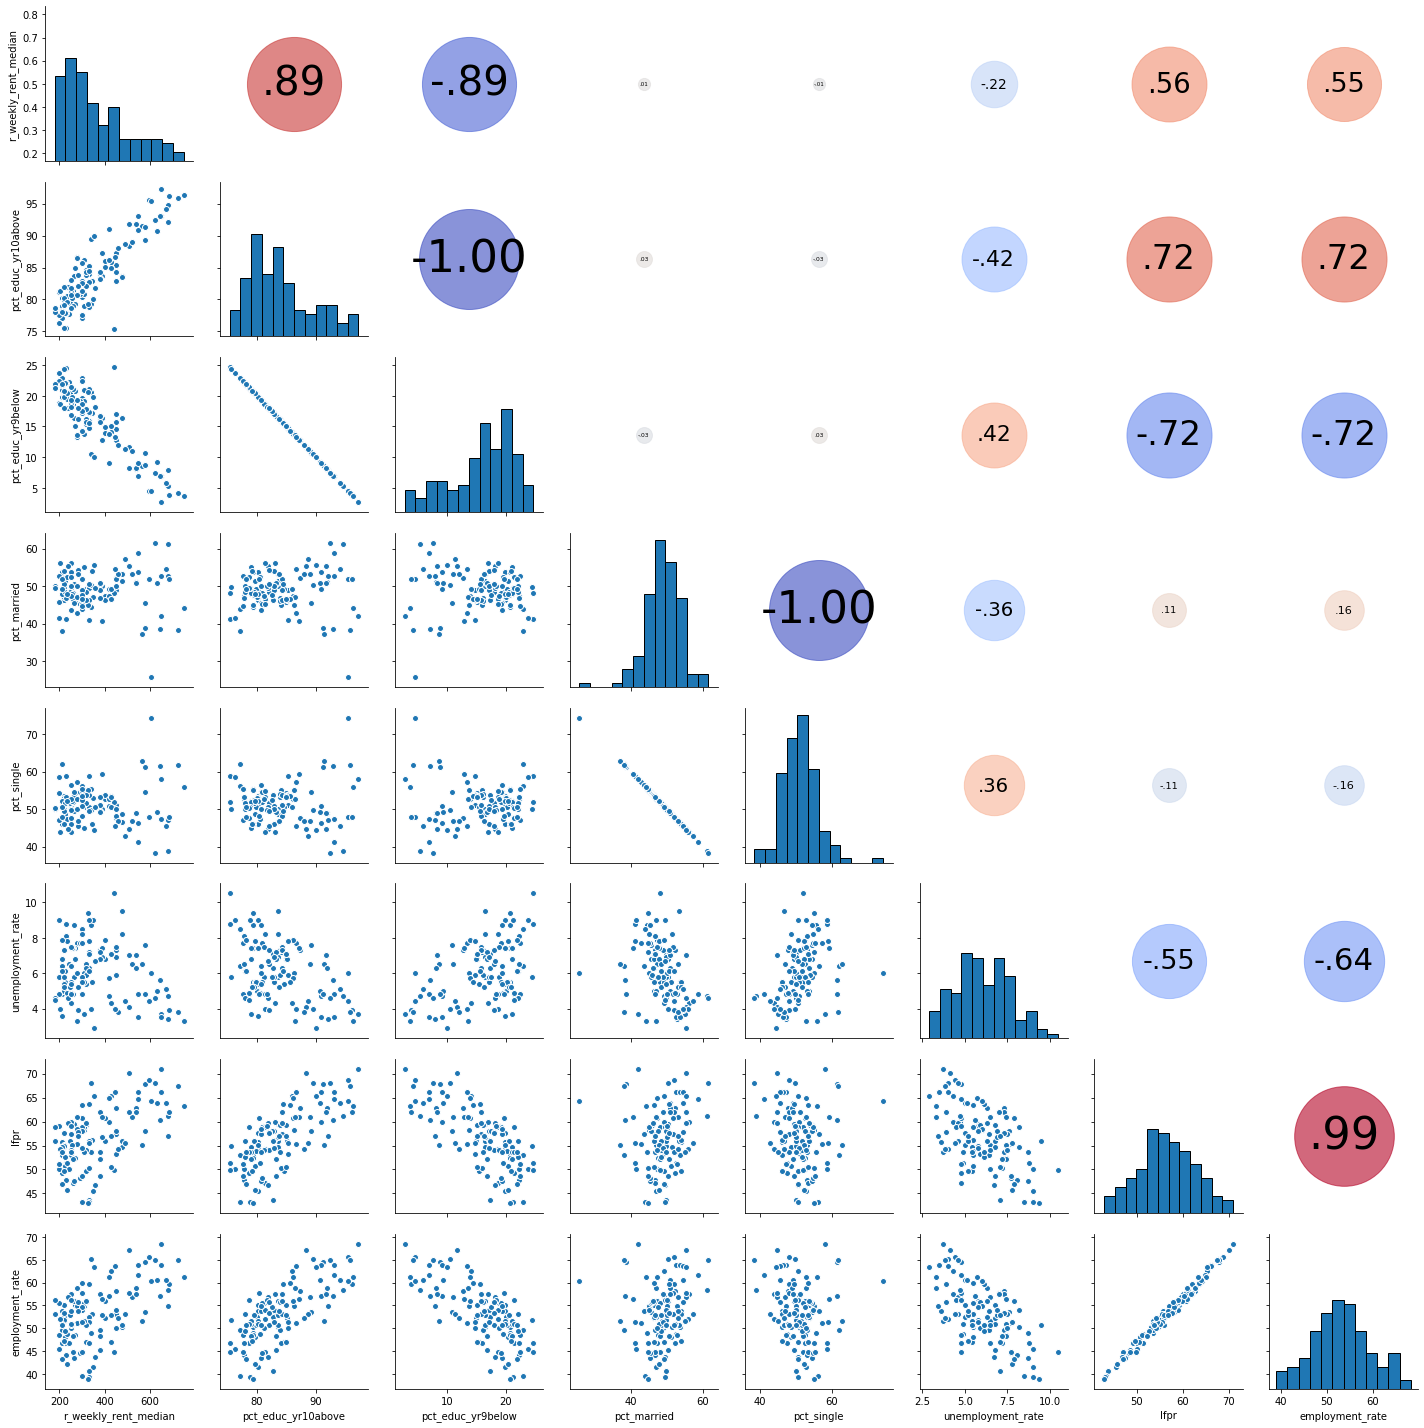

In [15]:
plot_03 = ['r_weekly_rent_median'] + X_census_educ + X_census_marital_stat + X_census_employment
corr_plot(rent_all, plot_03)

LGAs with more educated people, or those who have finished Year 10 and above at school, are associated with higher median weekly rent. Marital status don't seem to have any correlation with weekly rent at all. LGAs with higher labor force participation rate, or areas with more person who are working or looking for work, are associated with higher weekly rent.

In [16]:
rent_all[X_census_educ_qual].describe()

,pct_pgrad,pct_grad_cert_dip,pct_bach_deg,pct_adv_dip,pct_cert_iii_iv,pct_cert_i_ii,pct_others
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,5.750156,2.476669,20.041034,13.456575,29.601516,6.211318,22.462733
std,5.292514,0.886284,9.176919,1.913834,9.526529,1.409828,7.259692
min,1.371951,0.691443,10.180573,8.592777,5.916500,2.249352,9.385397
25%,2.146013,1.844912,13.766821,12.044062,26.614306,5.621422,17.233029
50%,3.498040,2.267127,15.730596,13.105748,33.177132,6.554141,22.115951
75%,7.030568,3.118561,22.717842,15.106586,36.048304,7.282988,27.934451
max,19.611817,4.733645,43.354304,17.937594,43.123857,8.258435,45.952677


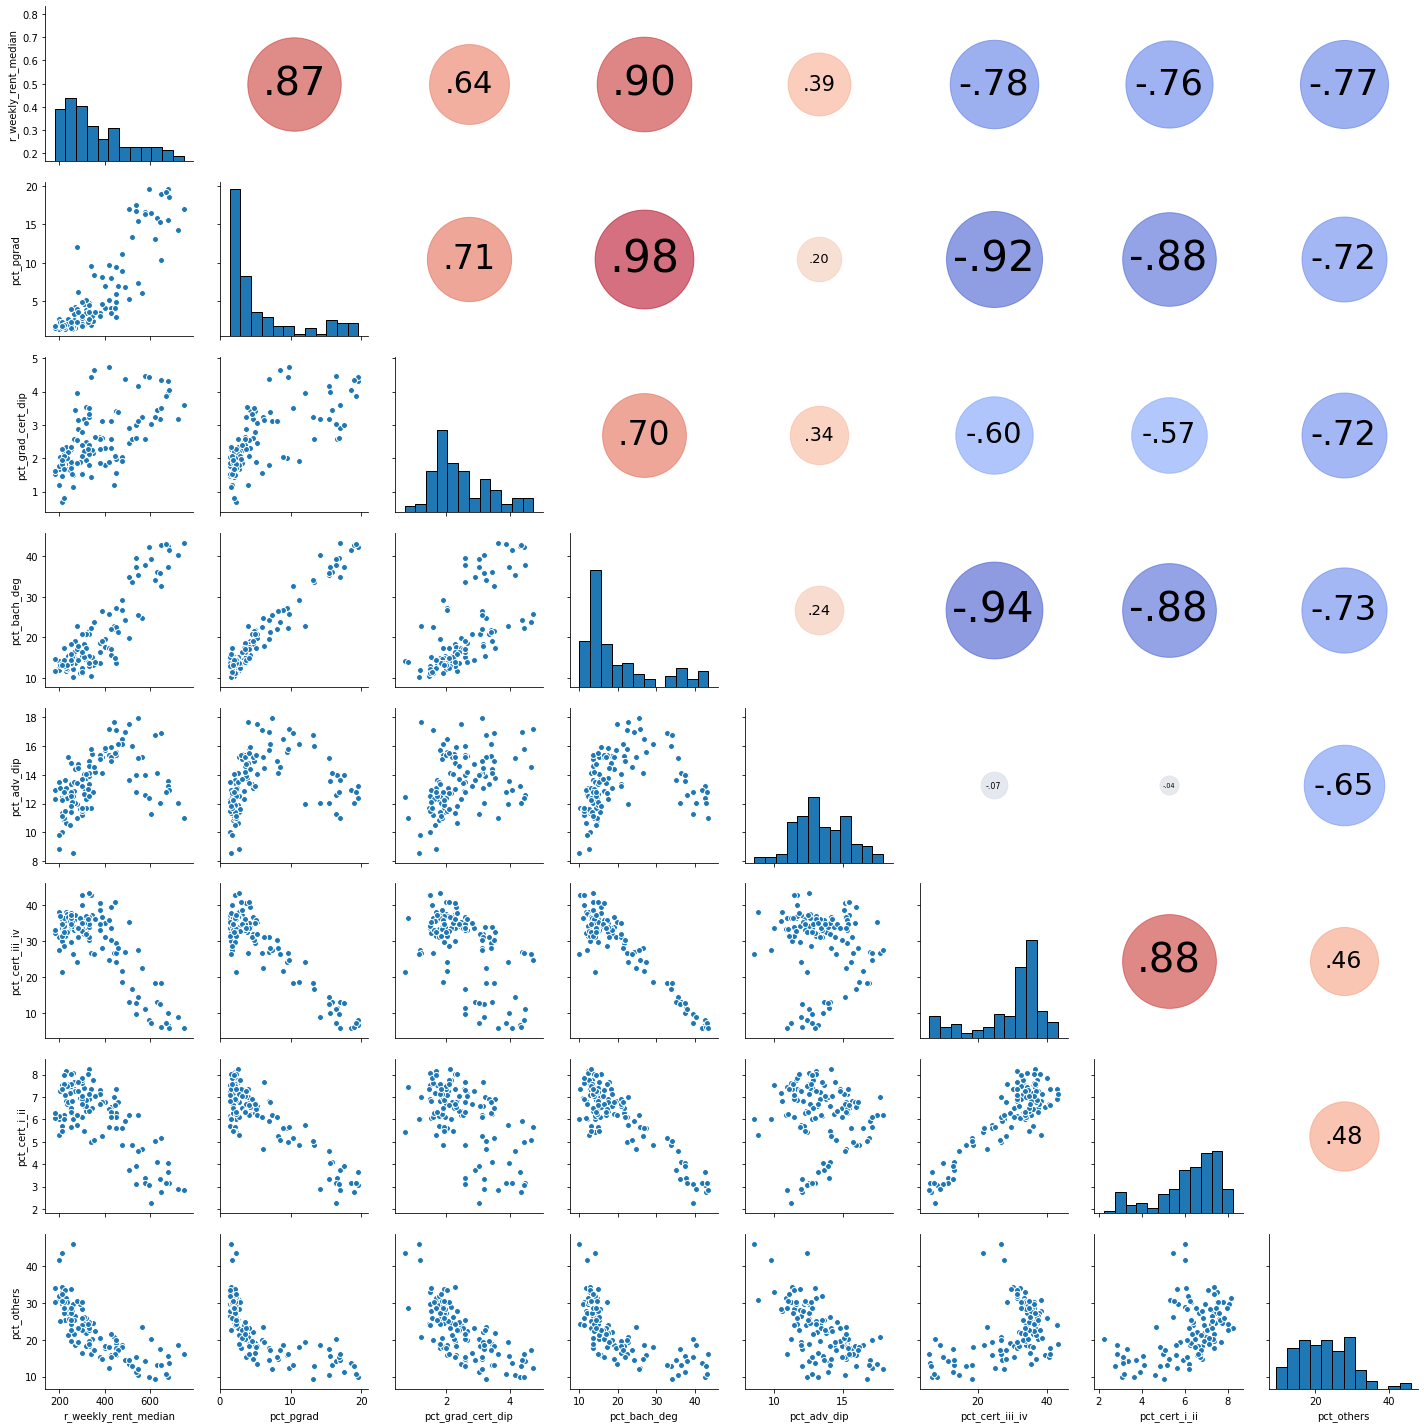

In [17]:
plot_04 = ['r_weekly_rent_median'] + X_census_educ_qual
corr_plot(rent_all, plot_04)

Similar to the education described earlier, LGA with higher percentage of people finishing higher education qualification are associated with higher rents.

In [18]:
rent_all[X_transpo].describe()

,bus_stop,bstop_per_land_area,train_station,tstation_per_land_area,all_transpo,transpo_per_land_area
count,121.000000,121.000000,121.000000,121.000000,121.000000,121.000000
mean,344.000000,3.590604,3.057851,0.029426,350.057851,3.633721
std,560.991622,6.993436,4.544773,0.077572,563.534978,7.077793
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000048
25%,10.000000,0.001359,0.000000,0.000000,13.000000,0.002436
50%,87.000000,0.022660,1.000000,0.000298,91.000000,0.024810
75%,385.000000,2.835425,4.000000,0.008328,391.000000,2.840399
max,3151.000000,26.308191,25.000000,0.486110,3165.000000,26.415135


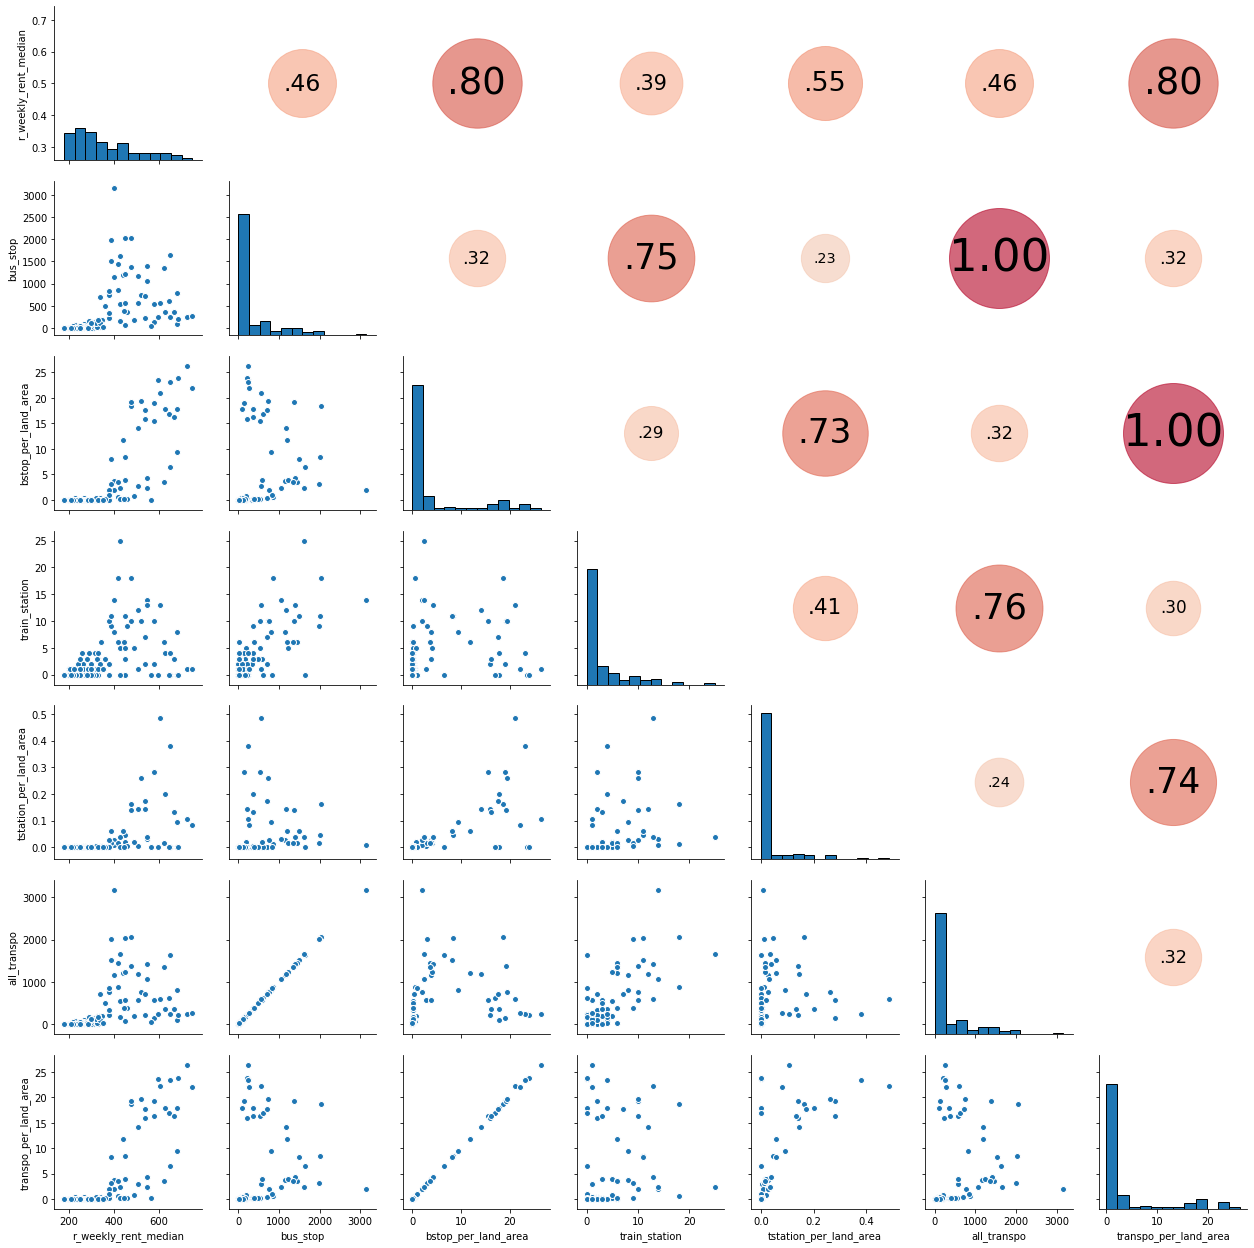

In [19]:
plot_05 = ['r_weekly_rent_median'] + X_transpo
corr_plot(rent_all, plot_05)

Count of bus stops scaled by land area has a high positive correlation with weekly rent which implies that more bus stops per land area are highly associated with higher median weekly rent. This might be expected as count of bus stops in an area can be interpreted as the degree of accessibility in an LGA. All transportation modes per land area also has a similar relationship with weekly rent.

In [20]:
rent_all[X_ntl].describe()

,land_area,ntl17_mean,ntl17_mean_per_land_area
count,121.00000,121.000000,121.000000
mean,4675.19434,4.395224,24.567173
std,6795.35834,8.903420,49.638635
min,5.71690,0.178377,0.955829
25%,311.91110,0.216118,1.182681
50%,2808.78220,0.302125,1.718910
75%,6022.34980,2.919664,16.414464
max,45579.32990,52.469931,290.378000


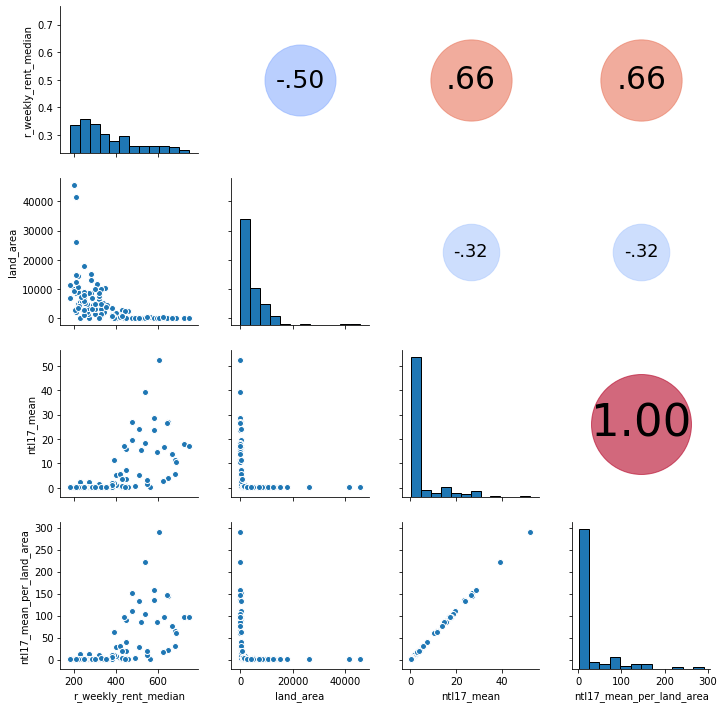

In [21]:
plot_06 = ['r_weekly_rent_median'] + X_ntl
corr_plot(rent_all, plot_06)

Nighttime lights measure the amount of light from an area that can be seen from space at night. We compute two statistics, the average of nighttime lights and the nighttime lights per land area. Both have a similar positive correlation with weekly rent. This means that more light emanating from an area, the higher the weekly rent is for that same area. We can view nighttime lights as an indicator of economic activity. 

Based on the correlation plots above, we narrow down our set of predictor variables to the following:

In [22]:
y_col = 'r_weekly_rent_median'
X_cols_census = ['pct_age_15_64', 'pct_birthplace_au', 'pct_educ_yr10above', 'lfpr', 'pct_bach_deg',
                 'median_weekly_hincome']
X_cols_transpo = ['bstop_per_land_area']
X_cols_ntl = ['ntl17_mean_per_land_area']
X_cols_all = X_cols_census + X_cols_transpo + X_cols_ntl

#### Overall Median Weekly Rent Linear Regression Modelling
We now proceed with the creation of the linear model for overall median weekly rent. We first fit the model using purely census variables, then transportation variables and nighttime lights variables. Next, we explore the model where the combined transportation and nighttime lights variables are the predictors. And finally, we create one model that contains census, transportation and nighttime lights variables.

We first create the training and testing datasets. We define separate training datasets for each set of variables and combine them as we go through the models.

In [23]:
train, test = train_test_split(rent_all, random_state = 42)

In [24]:
y_train = train[y_col]
y_test = test[y_col]
X_train_c = train[X_cols_census]
X_test_c = test[X_cols_census]
X_train_t = train[X_cols_transpo]
X_test_t = test[X_cols_transpo]
X_train_n = train[X_cols_ntl]
X_test_n = test[X_cols_ntl]
X_train_all = train[X_cols_all]
X_test_all = test[X_cols_all]

print('Dimensions of X_train: ', X_train_all.shape)
print('Dimensions of y_train: ', y_train.shape)
print('Dimensions of X_test: ', X_test_all.shape)
print('Dimensions of y_test: ', y_test.shape)

Dimensions of X_train:  (90, 8)
Dimensions of y_train:  (90,)
Dimensions of X_test:  (31, 8)
Dimensions of y_test:  (31,)


The training dataset contains 90 LGAs with a total of 8 features, from census, transportation and nighttime lights variables, while the testing dataset contains 31 LGAs.

#### Predicting Rent using Census Variables
We define functions that we will use throughout the whole modelling process.

1. The `lm_rent` function provides a method to quickly build the linear regression model given the independent variables and dependent variable.
2. The `model_assess` function provides several model assessment metrics to compare the performance of each regression runs.
3. The `print_assess` function displays the model assessment metrics results in each model. The following are used to assess the models:
    * __Root Mean Square Error__ (RMSE) is the square root of the variance of the residuals and measures how close/far the predicted values are from the actual values. Lower values of RMSE indicate that the predicted values are close to the actual values.
    * __Adjusted Coefficient of Determination__ (Adjusted $R^2$) measures how much of the variation in the response variable is explained by the linear model. Higher values of Adjusted $R^2$ mean that the model explains most of the variability on the response variable. Unlike $R^2$, Adjusted $R^2$ gets penalised as we add more variables to the model, so in order for Adjusted $R^2$ to improve, only relevant variables should be added to the model.
    * __Mean Absolute Error__ (MAE) measures the average magnitude of deviation of the predicted values from the actual values without considering the direction of the error.
    
The comparison of assessment metrics for all the models built will be discussed later on.

In [25]:
def lm_rent(df_X, df_y):
    lm = LinearRegression()
    lm.fit(df_X, df_y)
    return lm
    
def model_assess(model, df_X, df_y):
    y_pred = model.predict(df_X)
    rmse = np.sqrt(((np.array(df_y) - y_pred)**2).sum() / len(df_y))
    r2 = r2_score(df_y, y_pred)
    adj_r2 = 1 - (1 - r2) * (len(df_y) - 1) / (len(df_y) - df_X.shape[1] - 1)
    mae = mean_absolute_error(df_y, y_pred)
    return rmse, adj_r2, mae

def print_assess(model):
    print('Adjusted R squared: ', model[1])
    print('Mean Absolute Error: ', model[2])
    print('RMSE: ', model[0])

In [26]:
lm_rent_all_c = lm_rent(X_train_c, y_train)
lm_c_train = model_assess(lm_rent_all_c, X_train_c, y_train)
lm_c_test = model_assess(lm_rent_all_c, X_test_c, y_test)
print_assess(lm_c_train)
print_assess(lm_c_test)

Adjusted R squared:  0.9076163113728001
Mean Absolute Error:  35.43167610402252
RMSE:  41.764593544794955
Adjusted R squared:  0.8274442197446589
Mean Absolute Error:  40.45709947114829
RMSE:  53.06740842222564


Using all census variables, the Adjusted $R^2$ is 0.9076 for the training dataset and 0.8274 for the testing dataset. This means that appoximately 91% of the variation in the median weekly rent in the training dataset is explained by the model model and 82.74% of the variation in the median weekly rent in the testing dataset is explained by the model.

#### Predicting Rent using Transportation Variable
For transportation variables, we have included `bstop_per_land_area` only since it has a similar relationship as `transpo_per_land_area`. The variable `tstation_per_land_area` is omitted from the model.

In [27]:
lm_rent_all_t = lm_rent(X_train_t, y_train)
lm_t_train = model_assess(lm_rent_all_t, X_train_t, y_train)
lm_t_test = model_assess(lm_rent_all_t, X_test_t, y_test)
print_assess(lm_t_train)
print_assess(lm_t_test)

Adjusted R squared:  0.6766847948444346
Mean Absolute Error:  62.7719118878456
RMSE:  80.44998446846444
Adjusted R squared:  0.48121142815153106
Mean Absolute Error:  80.03582059635382
RMSE:  101.14669616435089


Using only `bstop_per_land_area` in the model gives an Adjusted $R^2$ of 0.6767 for the training dataset while it gives 0.4812 for the testing dataset.

#### Predicting Rent using Nighttime Lights Variable

In [28]:
lm_rent_all_n = lm_rent(X_train_n, y_train)
lm_n_train = model_assess(lm_rent_all_n, X_train_n, y_train)
lm_n_test = model_assess(lm_rent_all_n, X_test_n, y_test)
print_assess(lm_n_train)
print_assess(lm_n_test)

Adjusted R squared:  0.45348697308235764
Mean Absolute Error:  80.131581517947
RMSE:  104.59553823036327
Adjusted R squared:  0.32448242980727726
Mean Absolute Error:  93.16302262660936
RMSE:  115.41834060033322


Adjusted $R^2$ when using nighttime lights only is 0.4535 for training dataset and 0.3245 for testing dataset.

#### Predicting Rent with Transportation and Nighttime Lights Variables

In [29]:
X_train_tn = train[X_cols_transpo + X_cols_ntl]
X_test_tn = test[X_cols_transpo + X_cols_ntl]

lm_rent_all_tn = lm_rent(X_train_tn, y_train)
lm_tn_train = model_assess(lm_rent_all_tn, X_train_tn, y_train)
lm_tn_test = model_assess(lm_rent_all_tn, X_test_tn, y_test)
print_assess(lm_tn_train)
print_assess(lm_tn_test)

Adjusted R squared:  0.6781800657226622
Mean Absolute Error:  62.87617526233111
RMSE:  79.80638904797723
Adjusted R squared:  0.4576712982222503
Mean Absolute Error:  81.3401049136226
RMSE:  101.61733773609032


The model that combines transportation and nighttime lights variables doesn't lead to a better model as evidenced by the Adjusted $R^2$.

#### Predicting Rent using All Variables

In [30]:
lm_rent_all = lm_rent(X_train_all, y_train)
lm_train = model_assess(lm_rent_all, X_train_all, y_train)
lm_test = model_assess(lm_rent_all, X_test_all, y_test)
print_assess(lm_train)
print_assess(lm_test)

Adjusted R squared:  0.907791808687276
Mean Absolute Error:  35.03667509909045
RMSE:  41.21913036587415
Adjusted R squared:  0.8120407045081783
Mean Absolute Error:  40.78472645069354
RMSE:  53.02745047591427


Combining all variables in the model does not improve the predictive power as compared to just having the census variables in the model. Therefore, using only the census variables is enough to predict the median weekly rent per LGA.

In [31]:
rent_all_train_acc = [lm_c_train, lm_t_train, lm_n_train, lm_tn_train, lm_train]
rent_all_test_acc = [lm_c_test, lm_t_test, lm_n_test, lm_tn_test, lm_test]

In [32]:
model_metrics = ['rmse', 'adj_r2', 'mae']
model_predictors = ['all_census','bus_only', 'ntl', 'bus_ntl', 'all_data']

overall_rent_train = pd.DataFrame(columns = ['variables'] + model_metrics)
overall_rent_test = pd.DataFrame(columns = ['variables'] + model_metrics)

for i in rent_all_train_acc:
    overall_rent_train = overall_rent_train.append(pd.Series(i[0:3], index = model_metrics),
                                                   ignore_index = True)
overall_rent_train.variables = model_predictors

overall_rent_test = pd.DataFrame(columns = ['variables'] + model_metrics)
for i in rent_all_test_acc:
    overall_rent_test = overall_rent_test.append(pd.Series(i[0:3], index = model_metrics),
                                                   ignore_index = True)
overall_rent_test.variables = model_predictors

In [33]:
overall_rent_train

,variables,rmse,adj_r2,mae
0,all_census,41.764594,0.907616,35.431676
1,bus_only,80.449984,0.676685,62.771912
2,ntl,104.595538,0.453487,80.131582
3,bus_ntl,79.806389,0.678180,62.876175
4,all_data,41.219130,0.907792,35.036675


In [34]:
overall_rent_test

,variables,rmse,adj_r2,mae
0,all_census,53.067408,0.827444,40.457099
1,bus_only,101.146696,0.481211,80.035821
2,ntl,115.418341,0.324482,93.163023
3,bus_ntl,101.617338,0.457671,81.340105
4,all_data,53.027450,0.812041,40.784726


#### Reduce Number of Predictors for the Overall Median Weekly Rent Model
We now check if we can reduce the number of variables in the model by using the recursive feature elimination algorithm. We test what the predictive power be if we limit the number of predictors just half of what we currently have.

We define the following functions to execute the feature elimination process:
1. The `rfe_mlr` function provides a method to run the multiple linear regression algorithm with the recursive feature elimination.
2. The `list_rfe_pred` function displays the top n features selected by the RFE algorithm.

In [35]:
def rfe_mlr(n, df_X, df_y):
    model = LinearRegression()
    rfe = RFE(estimator = model, n_features_to_select = n, step = 1)
    rfe.fit(df_X, df_y)
    return rfe

def list_rfe_pred(model, df_X):
    features_bool = np.array(model.support_)
    features = np.array(df_X.columns)
    result = features[features_bool]
    return result

In [36]:
top4 = rfe_mlr(4, X_train_all, y_train)
print(list_rfe_pred(top4, X_train_all))

['pct_age_15_64' 'pct_birthplace_au' 'pct_educ_yr10above'
 'bstop_per_land_area']


In [37]:
print("y = x *", top4.estimator_.coef_, "+", top4.estimator_.intercept_)

y = x * [-4.48102197 -3.03786238 16.13012413  3.88638561] + -471.5795952344763


The top 4 most important variables in predicting median weekly rent are:
* Percentage of person aged between 15 and 64 years (`pct_age_15_64`)
* Percentage of person who were born in Australia (`pct_birthplace_au`)
* Percentage of person who have completed Year 10 and above (`pct_educ_yr10above`)
* Count of bus stops per land area (`bstop_per_land_area`)

In [38]:
top4_train_assess = model_assess(top4, X_train_all, y_train)
print_assess(top4_train_assess)

Adjusted R squared:  0.8616782241751914
Mean Absolute Error:  42.78722128902667
RMSE:  50.484650168721856


In [39]:
top4_test_assess = model_assess(top4, X_test_all, y_test)
print_assess(top4_test_assess)

Adjusted R squared:  0.8216470912610535
Mean Absolute Error:  44.42235295335783
RMSE:  51.65459265393643


In [40]:
overall_rent_train = overall_rent_train.append(pd.Series(top4_train_assess[0:3], index = model_metrics),
                                               ignore_index = True)
overall_rent_train.variables[5] = 'top_4_predictors'
overall_rent_train

,variables,rmse,adj_r2,mae
0,all_census,41.764594,0.907616,35.431676
1,bus_only,80.449984,0.676685,62.771912
2,ntl,104.595538,0.453487,80.131582
3,bus_ntl,79.806389,0.678180,62.876175
4,all_data,41.219130,0.907792,35.036675
5,top_4_predictors,50.484650,0.861678,42.787221


In [41]:
overall_rent_test = overall_rent_test.append(pd.Series(top4_test_assess[0:3], index = model_metrics),
                                             ignore_index = True)
overall_rent_test.variables[5] = 'top_4_predictors'
overall_rent_test

,variables,rmse,adj_r2,mae
0,all_census,53.067408,0.827444,40.457099
1,bus_only,101.146696,0.481211,80.035821
2,ntl,115.418341,0.324482,93.163023
3,bus_ntl,101.617338,0.457671,81.340105
4,all_data,53.027450,0.812041,40.784726
5,top_4_predictors,51.654593,0.821647,44.422353


In [42]:
overall_rent_train['dataset'] = 'train'
overall_rent_test['dataset'] = 'test'
overall_rent_acc = pd.concat([overall_rent_train, overall_rent_test], axis = 0)

Text(0.5, 1.0, 'Adjusted $R^2$ of Overall Median Weekly Rent Models')

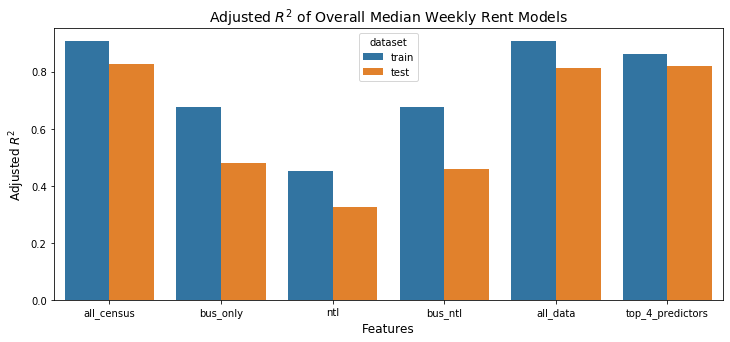

In [43]:
plt.figure(figsize = (12, 5))
ax = sns.barplot(x = 'variables', y = 'adj_r2', hue = 'dataset', data = overall_rent_acc)
ax.set_xlabel('Features', fontsize = 12)
ax.set_ylabel('Adjusted $R^2$', fontsize = 12)
ax.set_title('Adjusted $R^2$ of Overall Median Weekly Rent Models', size = 14)

Text(0.5, 1.0, 'Root Mean Squared Error of Overall Median Weekly Rent Models')

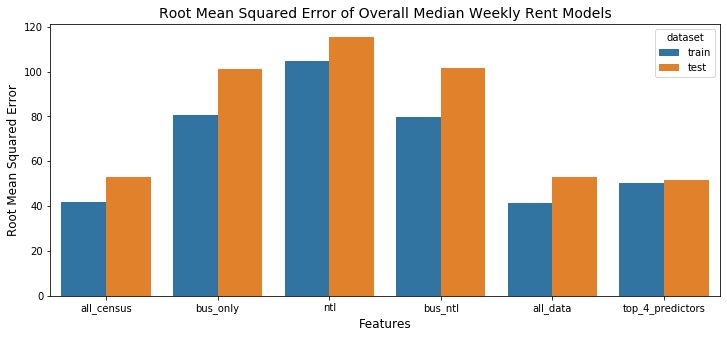

In [44]:
plt.figure(figsize = (12, 5))
ax = sns.barplot(x = 'variables', y = 'rmse', hue = 'dataset', data = overall_rent_acc)
ax.set_xlabel('Features', fontsize = 12)
ax.set_ylabel('Root Mean Squared Error', fontsize = 12)
ax.set_title('Root Mean Squared Error of Overall Median Weekly Rent Models', size = 14)

Text(0.5, 1.0, 'Mean Absolute Error of Overall Median Weekly Rent Models')

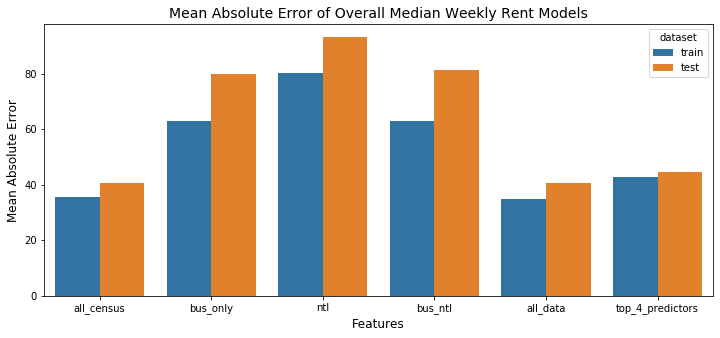

In [45]:
plt.figure(figsize = (12, 5))
ax = sns.barplot(x = 'variables', y = 'mae', hue = 'dataset', data = overall_rent_acc)
ax.set_xlabel('Features', fontsize = 12)
ax.set_ylabel('Mean Absolute Error', fontsize = 12)
ax.set_title('Mean Absolute Error of Overall Median Weekly Rent Models', size = 14)

### Median Weekly Rent by Bedroom
We now look at the median weekly rent by the number of bedrooms. We proceed by using a similar approach and add new (dummy) variables in our model corresponding to the number of bedrooms in a given property by LGA.

In [46]:
rent_br = rent_df.melt(id_vars = ['LGA_CODE'], value_vars = ['r_one_br', 'r_two_br', 'r_three_br',
                                                             'r_four_or_more_br', 'r_bedsitter'])
rent_br = rent_br[rent_br.value > 0]

In [47]:
rent_bedroom = rent_all.merge(rent_br, on = 'LGA_CODE', how = 'inner')
rent_bedroom = rent_bedroom.drop(columns = ['r_one_br', 'r_two_br', 'r_three_br', 'r_four_or_more_br', 'r_bedsitter',
                                            'r_not_specified', 'r_flat', 'r_house', 'r_other', 'r_townhouse',
                                            'r_weekly_rent_median'])
rent_bedroom = rent_bedroom.rename(columns = {'variable' : 'bedroom', 'value' : 'weekly_rent_median'})

In [48]:
print('Dimensions of the rent_bedroom dataset: ', rent_bedroom.shape)
print('The number of LGAs represented in the dataset is: ', len(rent_bedroom.LGA_CODE.unique()))
rent_bedroom.head()

Dimensions of the rent_bedroom dataset:  (375, 37)
The number of LGAs represented in the dataset is:  110


,LGA_CODE,LGA_NAME,pct_age_14below,pct_age_15_64,pct_age_65above,pct_birthplace_au,pct_birthplace_non_au,pct_educ_yr10above,pct_educ_yr9below,pct_married,...,bstop_per_land_area,train_station,tstation_per_land_area,all_transpo,transpo_per_land_area,land_area,ntl17_mean,ntl17_mean_per_land_area,bedroom,weekly_rent_median
0,LGA10050,Albury,18.817404,63.275332,17.907264,88.245279,11.754721,84.962606,15.037394,45.658412,...,0.294170,1.0,0.003269,91.0,0.297438,305.9459,2.375328,13.711019,r_one_br,162.5
1,LGA10050,Albury,18.817404,63.275332,17.907264,88.245279,11.754721,84.962606,15.037394,45.658412,...,0.294170,1.0,0.003269,91.0,0.297438,305.9459,2.375328,13.711019,r_two_br,220.0
2,LGA10050,Albury,18.817404,63.275332,17.907264,88.245279,11.754721,84.962606,15.037394,45.658412,...,0.294170,1.0,0.003269,91.0,0.297438,305.9459,2.375328,13.711019,r_three_br,290.0
3,LGA10050,Albury,18.817404,63.275332,17.907264,88.245279,11.754721,84.962606,15.037394,45.658412,...,0.294170,1.0,0.003269,91.0,0.297438,305.9459,2.375328,13.711019,r_four_or_more_br,375.0
4,LGA10130,Armidale Regional,18.117000,64.937358,16.945642,86.565287,13.434713,86.689028,13.310972,42.869580,...,0.001972,1.0,0.000116,21.0,0.002436,8620.6990,0.210830,1.139977,r_one_br,170.0


The `rent_bedroom` dataset contains 375 observations, with 110 unique LGAs represented in the dataset.

count     375.000000
mean      431.849333
std       273.072921
min       120.000000
25%       260.000000
50%       360.000000
75%       500.000000
max      2250.000000
Name: weekly_rent_median, dtype: float64

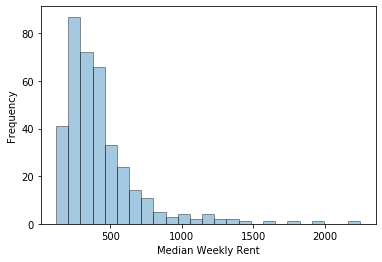

In [49]:
ax = sns.distplot(rent_bedroom.weekly_rent_median, bins = 25, kde = False, hist_kws = dict(edgecolor = 'k'))
ax.set(xlabel = 'Median Weekly Rent', ylabel = 'Frequency')
rent_bedroom.weekly_rent_median.describe()

bedroom weekly_rent_median                                 \
                                  count        mean         std    min   
0        r_bedsitter               13.0  376.038462   54.556722  280.0   
1  r_four_or_more_br               87.0  629.798851  392.346700  280.0   
2           r_one_br               71.0  300.000000  131.673297  120.0   
3         r_three_br              110.0  433.522727  230.230064  200.0   
4           r_two_br               94.0  353.989362  159.613242  155.0   

                                 
      25%    50%    75%     max  
0  340.00  380.0  425.0   437.0  
1  397.50  480.0  695.0  2250.0  
2  200.00  260.0  410.0   575.0  
3  270.00  350.0  470.0  1220.0  
4  236.25  300.0  427.5   780.0

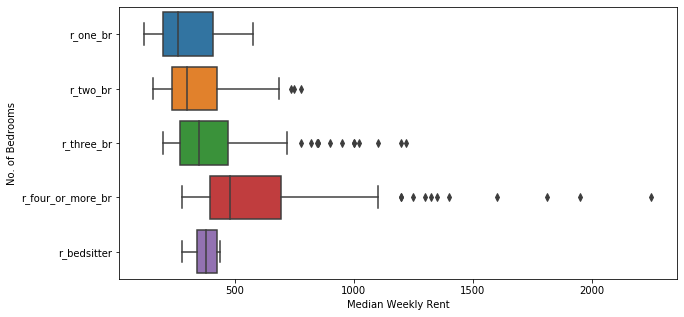

In [50]:
plt.figure(figsize = (10, 5))
ax = sns.boxplot(x = 'weekly_rent_median', y = 'bedroom', data = rent_bedroom)
ax.set(xlabel = 'Median Weekly Rent', ylabel = 'No. of Bedrooms')
rent_bedroom[['bedroom', 'weekly_rent_median']].groupby('bedroom').describe().reset_index()

The weekly rent dataset is skewed to the right with most of the data falling below 500. The average median weekly rent is 431.85 and 50% of the LGAs have median weekly rent of more than 360. The minimum median weekly rent is 120 and the maximum weekly median rent is 2250.

The rent is proportionally growing as the number of bedrooms increase. On average, the median weekly rent for a bedsitter is more expensive than a one and two bedroom property. Bedsitters are the least represented in the dataset with only 13 properties.

#### Median Weekly Rent by Bedroom Linear Regression Modelling

In [51]:
train, test = train_test_split(rent_bedroom, stratify = rent_bedroom['bedroom'], random_state = 42)
print('Dimension of the training dataset: ', train.shape)
print('Dimension of the testing dataset: ', test.shape)

Dimension of the training dataset:  (281, 37)
Dimension of the testing dataset:  (94, 37)


Using a similar approach as the overall median weekly rent modelling, we split the data for training and testing. We use the `stratify` parameter of the `train_test_split` to get an accurate distribution of properties per bedroom number. The training dataset contains 281 observations while the testing dataset contains 94 observations.

In [52]:
X_train = train.drop(columns = ['weekly_rent_median'])
y_train = train['weekly_rent_median']
X_test = test.drop(columns = ['weekly_rent_median'])
y_test = test['weekly_rent_median']

In [53]:
dtr_bedroom = pd.get_dummies(X_train.bedroom, drop_first = True)
dte_bedroom = pd.get_dummies(X_test.bedroom, drop_first = True)
X_train = X_train.merge(dtr_bedroom, how = 'inner', left_index = True, right_index = True)
X_test = X_test.merge(dte_bedroom, how = 'inner', left_index = True, right_index = True)

In [54]:
X_cols_br = ['r_four_or_more_br', 'r_one_br', 'r_three_br', 'r_two_br']
X_train_c = X_train[X_cols_census + X_cols_br]
X_test_c = X_test[X_cols_census + X_cols_br]
X_train_t = X_train[X_cols_transpo + X_cols_br]
X_test_t = X_test[X_cols_transpo + X_cols_br]
X_train_n = X_train[X_cols_ntl + X_cols_br]
X_test_n = X_test[X_cols_ntl + X_cols_br]
X_train_all = X_train[X_cols_all + X_cols_br]
X_test_all = X_test[X_cols_all + X_cols_br]

#### Predicting Rent by Bedroom using Census Variables

In [55]:
lm_rent_br_c = lm_rent(X_train_c, y_train)
lm_br_c_train = model_assess(lm_rent_br_c, X_train_c, y_train)
lm_br_c_test = model_assess(lm_rent_br_c, X_test_c, y_test)
print_assess(lm_br_c_train)
print_assess(lm_br_c_test)

Adjusted R squared:  0.7786268379015134
Mean Absolute Error:  73.08592641110849
RMSE:  116.40312252817569
Adjusted R squared:  0.6934190476129645
Mean Absolute Error:  90.62453336022506
RMSE:  168.07630073408063


Using all census variables with bedroom number as dummy variables, we get an Adjusted $R^2$ of 0.7786 for the training dataset and 0.6934 for the testing dataset.

#### Predicting Rent by Bedroom using Transportation Variable

In [56]:
lm_rent_br_t = lm_rent(X_train_t, y_train)
lm_br_t_train = model_assess(lm_rent_br_t, X_train_t, y_train)
lm_br_t_test = model_assess(lm_rent_br_t, X_test_t, y_test)
print_assess(lm_br_t_train)
print_assess(lm_br_t_test)

Adjusted R squared:  0.6742687415998847
Mean Absolute Error:  97.45375386849061
RMSE:  142.50048076815634
Adjusted R squared:  0.6206891821148277
Mean Absolute Error:  117.78916984604717
RMSE:  192.5013594032306


Similar to the overall median weekly rent prediction, `bstop_per_land_area` a fairly good predicting power in the median weekly rent by bedroom model.

#### Predicting Rent by Bedroom using Nighttime Lights Variable

In [57]:
lm_rent_br_n = lm_rent(X_train_n, y_train)
lm_br_n_train = model_assess(lm_rent_br_n, X_train_n, y_train)
lm_br_n_test = model_assess(lm_rent_br_n, X_test_n, y_test)
print_assess(lm_br_n_train)
print_assess(lm_br_n_test)

Adjusted R squared:  0.48323367504463277
Mean Absolute Error:  112.87623368466437
RMSE:  179.48729545480163
Adjusted R squared:  0.39351821893677963
Mean Absolute Error:  138.76714682844886
RMSE:  243.41372686794813


With nighttime lights as the predictor with bedroom number as dummy variables, the Adjusted $R^2$ is 0.4832 for the training dataset and 0.3935 for the testing dataset.

#### Predicting Rent by Bedroom using Transportation and Nighttime Lights Variables

In [58]:
X_train_tn = X_train[X_cols_transpo + X_cols_ntl + X_cols_br]
X_test_tn = X_test[X_cols_transpo + X_cols_ntl + X_cols_br]

lm_rent_br_tn = lm_rent(X_train_tn, y_train)
lm_br_tn_train = model_assess(lm_rent_br_tn, X_train_tn, y_train)
lm_br_tn_test = model_assess(lm_rent_br_tn, X_test_tn, y_test)
print_assess(lm_br_tn_train)
print_assess(lm_br_tn_test)

Adjusted R squared:  0.6761866943636974
Mean Absolute Error:  96.94317566848575
RMSE:  141.82176651268773
Adjusted R squared:  0.6285771945899294
Mean Absolute Error:  116.63404303324377
RMSE:  189.40383119741008


As with the overall median weekly rent model, combining transportation and nighttime lights variables don’t lead to a better model as evidenced by the Adjusted $R^2$.

#### Predicting Rent by Bedroom using All Variables

In [59]:
lm_rent_br = lm_rent(X_train_all, y_train)
lm_br_train = model_assess(lm_rent_br, X_train_all, y_train)
lm_br_test = model_assess(lm_rent_br, X_test_all, y_test)
print_assess(lm_br_train)
print_assess(lm_br_test)

Adjusted R squared:  0.7930297886886601
Mean Absolute Error:  70.95071494103024
RMSE:  112.13510205745472
Adjusted R squared:  0.7160443830638245
Mean Absolute Error:  88.37077016167507
RMSE:  159.79478127411767


Combining all variables in the model does not improve the predictive power as compared to
just having the census variables in the model. Therefore, using only the census variables is enough
to predict the median weekly rent by bedroom per LGA.

In [60]:
rent_br_train_acc = [lm_br_c_train, lm_br_t_train, lm_br_n_train, lm_br_tn_train, lm_br_train]
rent_br_test_acc = [lm_br_c_test, lm_br_t_test, lm_br_n_test, lm_br_tn_test, lm_br_test]

In [61]:
rent_bedroom_train = pd.DataFrame(columns = ['variables'] + model_metrics)
rent_bedroom_test = pd.DataFrame(columns = ['variables'] + model_metrics)

for i in rent_br_train_acc:
    rent_bedroom_train = rent_bedroom_train.append(pd.Series(i[0:3], index = model_metrics),
                                                   ignore_index = True)
rent_bedroom_train.variables = model_predictors

overall_rent_test = pd.DataFrame(columns = ['variables'] + model_metrics)
for i in rent_br_test_acc:
    rent_bedroom_test = rent_bedroom_test.append(pd.Series(i[0:3], index = model_metrics),
                                                   ignore_index = True)
rent_bedroom_test.variables = model_predictors

In [62]:
rent_bedroom_train

,variables,rmse,adj_r2,mae
0,all_census,116.403123,0.778627,73.085926
1,bus_only,142.500481,0.674269,97.453754
2,ntl,179.487295,0.483234,112.876234
3,bus_ntl,141.821767,0.676187,96.943176
4,all_data,112.135102,0.793030,70.950715


In [63]:
rent_bedroom_test

,variables,rmse,adj_r2,mae
0,all_census,168.076301,0.693419,90.624533
1,bus_only,192.501359,0.620689,117.789170
2,ntl,243.413727,0.393518,138.767147
3,bus_ntl,189.403831,0.628577,116.634043
4,all_data,159.794781,0.716044,88.370770


#### Reduce Number of Predictors for the Median Weekly Rent Model by Bedroom
Again, we explore if we can reduce the number of variables in the model by using the recursive feature elimination
algorithm. We test what the predictive power be if we limit the number of predictors just half of
what we currently have.

In [64]:
top6_br = rfe_mlr(6, X_train_all, y_train)
print(list_rfe_pred(top6_br, X_train_all))

['pct_educ_yr10above' 'bstop_per_land_area' 'r_four_or_more_br' 'r_one_br'
 'r_three_br' 'r_two_br']


In [65]:
print("y = x *", top6_br.estimator_.coef_, "+", top6_br.estimator_.intercept_)

y = x * [ 20.71916173  14.32303449 482.855022   143.22500282 346.65853994
 243.16384696] + -1720.4034331546404


In [66]:
top6_br_train_assess = model_assess(top6_br, X_train_all, y_train)
print_assess(top6_br_train_assess)

Adjusted R squared:  0.7693670937520212
Mean Absolute Error:  77.1676879409959
RMSE:  118.37181233696411


In [67]:
top6_br_test_assess = model_assess(top6_br, X_test_all, y_test)
print_assess(top6_br_test_assess)

Adjusted R squared:  0.6869112188411729
Mean Absolute Error:  96.48394415247736
RMSE:  167.79194667033408


The top 6 most important variables in predicting weekly median rent by bedroom are:
* Percentage of person who have completed Year 10 and above (`pct_educ_yr10above`)
* Count of bus stops per land area (`bstop_per_land_area`)
* Indicator for four or more bedroom property (`r_four_or_more_br`)
* Indicator for one bedroom property (`r_one_br`)
* Indicator for three bedroom property (`r_three_br`)
* Indicator for two bedroom property (`r_two_br`)

In [68]:
rent_bedroom_train = rent_bedroom_train.append(pd.Series(top6_br_train_assess[0:3], index = model_metrics),
                                               ignore_index = True)
rent_bedroom_train.variables[5] = 'top_6_predictors'
rent_bedroom_train

,variables,rmse,adj_r2,mae
0,all_census,116.403123,0.778627,73.085926
1,bus_only,142.500481,0.674269,97.453754
2,ntl,179.487295,0.483234,112.876234
3,bus_ntl,141.821767,0.676187,96.943176
4,all_data,112.135102,0.793030,70.950715
5,top_6_predictors,118.371812,0.769367,77.167688


In [69]:
rent_bedroom_test = rent_bedroom_test.append(pd.Series(top6_br_test_assess[0:3], index = model_metrics),
                                             ignore_index = True)
rent_bedroom_test.variables[5] = 'top_6_predictors'
rent_bedroom_test

,variables,rmse,adj_r2,mae
0,all_census,168.076301,0.693419,90.624533
1,bus_only,192.501359,0.620689,117.789170
2,ntl,243.413727,0.393518,138.767147
3,bus_ntl,189.403831,0.628577,116.634043
4,all_data,159.794781,0.716044,88.370770
5,top_6_predictors,167.791947,0.686911,96.483944


In [70]:
rent_bedroom_train['dataset'] = 'train'
rent_bedroom_test['dataset'] = 'test'
rent_bedroom_acc = pd.concat([rent_bedroom_train, rent_bedroom_test], axis = 0)

Text(0.5, 1.0, 'Adjusted $R^2$ of Median Weekly Rent by Bedroom Models')

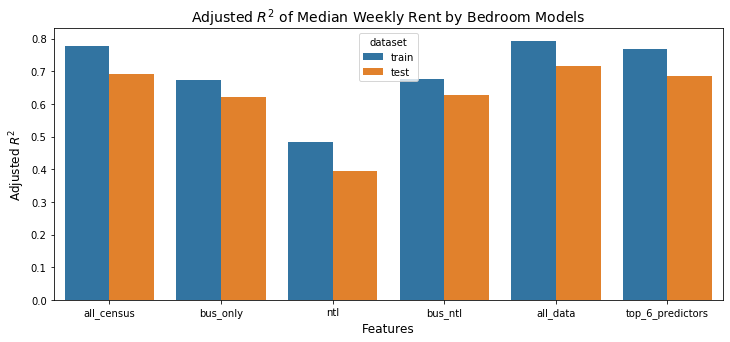

In [71]:
plt.figure(figsize = (12, 5))
ax = sns.barplot(x = 'variables', y = 'adj_r2', hue = 'dataset', data = rent_bedroom_acc)
ax.set_xlabel('Features', fontsize = 12)
ax.set_ylabel('Adjusted $R^2$', fontsize = 12)
ax.set_title('Adjusted $R^2$ of Median Weekly Rent by Bedroom Models', size = 14)

Text(0.5, 1.0, 'Root Mean Squared Error of Median Weekly Rent by Bedroom Models')

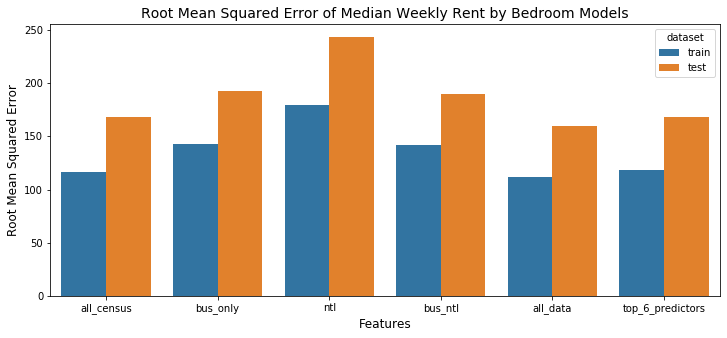

In [72]:
plt.figure(figsize = (12, 5))
ax = sns.barplot(x = 'variables', y = 'rmse', hue = 'dataset', data = rent_bedroom_acc)
ax.set_xlabel('Features', fontsize = 12)
ax.set_ylabel('Root Mean Squared Error', fontsize = 12)
ax.set_title('Root Mean Squared Error of Median Weekly Rent by Bedroom Models', size = 14)

Text(0.5, 1.0, 'Mean Absolute Error of Median Weekly Rent by Bedroom Models')

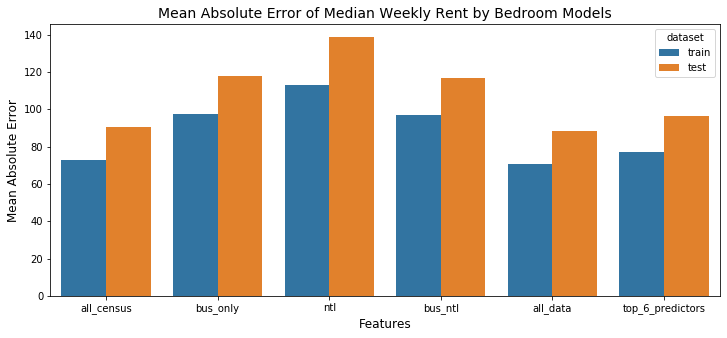

In [73]:
plt.figure(figsize = (12, 5))
ax = sns.barplot(x = 'variables', y = 'mae', hue = 'dataset', data = rent_bedroom_acc)
ax.set_xlabel('Features', fontsize = 12)
ax.set_ylabel('Mean Absolute Error', fontsize = 12)
ax.set_title('Mean Absolute Error of Median Weekly Rent by Bedroom Models', size = 14)

### Median Weekly Rent by Dwelling Type 2017
We use the same approach as before and add new (dummy) variables in our model corresponding to the dwelling type of the property by LGA.

In [74]:
rent_dw = rent_df.melt(id_vars = ['LGA_CODE'], value_vars = ['r_flat', 'r_house', 'r_other', 'r_townhouse'])
rent_dw = rent_dw[rent_dw.value > 0]

In [75]:
rent_dwell = rent_all.merge(rent_dw, on = 'LGA_CODE', how = 'inner')
rent_dwell = rent_dwell.drop(columns = ['r_one_br', 'r_two_br', 'r_three_br', 'r_four_or_more_br', 'r_bedsitter',
                                          'r_not_specified', 'r_flat', 'r_house', 'r_other', 'r_townhouse',
                                          'r_weekly_rent_median'])
rent_dwell = rent_dwell.rename(columns = {'variable' : 'dwell_type', 'value' : 'weekly_rent_median'})

In [76]:
print('Dimensions of the rent_dwell dataset: ', rent_dwell.shape)
print('The number of LGAs represented in the dataset is: ', len(rent_dwell.LGA_CODE.unique()))
rent_dwell.head()

Dimensions of the rent_dwell dataset:  (346, 37)
The number of LGAs represented in the dataset is:  116


,LGA_CODE,LGA_NAME,pct_age_14below,pct_age_15_64,pct_age_65above,pct_birthplace_au,pct_birthplace_non_au,pct_educ_yr10above,pct_educ_yr9below,pct_married,...,bstop_per_land_area,train_station,tstation_per_land_area,all_transpo,transpo_per_land_area,land_area,ntl17_mean,ntl17_mean_per_land_area,dwell_type,weekly_rent_median
0,LGA10050,Albury,18.817404,63.275332,17.907264,88.245279,11.754721,84.962606,15.037394,45.658412,...,0.294170,1.0,0.003269,91.0,0.297438,305.9459,2.375328,13.711019,r_flat,200.0
1,LGA10050,Albury,18.817404,63.275332,17.907264,88.245279,11.754721,84.962606,15.037394,45.658412,...,0.294170,1.0,0.003269,91.0,0.297438,305.9459,2.375328,13.711019,r_house,310.0
2,LGA10050,Albury,18.817404,63.275332,17.907264,88.245279,11.754721,84.962606,15.037394,45.658412,...,0.294170,1.0,0.003269,91.0,0.297438,305.9459,2.375328,13.711019,r_other,277.5
3,LGA10050,Albury,18.817404,63.275332,17.907264,88.245279,11.754721,84.962606,15.037394,45.658412,...,0.294170,1.0,0.003269,91.0,0.297438,305.9459,2.375328,13.711019,r_townhouse,277.5
4,LGA10130,Armidale Regional,18.117000,64.937358,16.945642,86.565287,13.434713,86.689028,13.310972,42.869580,...,0.001972,1.0,0.000116,21.0,0.002436,8620.6990,0.210830,1.139977,r_flat,230.0


The `rent_dwell` dataset contains 346 observations, with 116 unique LGAs represented in the dataset.

count     346.000000
mean      415.604046
std       202.994215
min       140.000000
25%       280.000000
50%       352.500000
75%       500.000000
max      1500.000000
Name: weekly_rent_median, dtype: float64

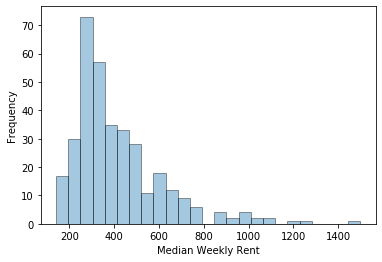

In [77]:
ax = sns.distplot(rent_dwell.weekly_rent_median, bins = 25, kde = False, hist_kws = dict(edgecolor = 'k'))
ax.set(xlabel = 'Median Weekly Rent', ylabel = 'Frequency')
rent_dwell.weekly_rent_median.describe()

dwell_type weekly_rent_median                                        \
                            count        mean         std    min    25%   
0       r_flat               95.0  333.078947  149.468675  140.0  225.0   
1      r_house              116.0  438.577586  243.572421  200.0  270.0   
2      r_other               70.0  407.700000  122.828424  240.0  300.0   
3  r_townhouse               65.0  503.730769  217.772873  277.5  340.0   

                           
      50%     75%     max  
0  280.00  420.00   700.0  
1  350.00  502.50  1500.0  
2  373.75  493.75   710.0  
3  430.00  600.00  1272.5

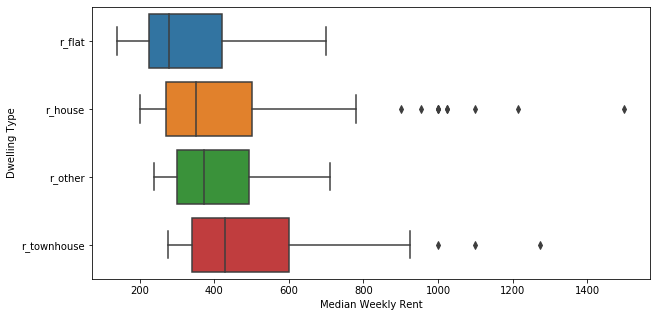

In [78]:
plt.figure(figsize = (10, 5))
ax = sns.boxplot(x = 'weekly_rent_median', y = 'dwell_type', data = rent_dwell)
ax.set(xlabel = 'Median Weekly Rent', ylabel = 'Dwelling Type')
rent_dwell[['dwell_type', 'weekly_rent_median']].groupby('dwell_type').describe().reset_index()

The weekly rent by dwelling type dataset is skewed to the right with most of the data falling below 400. The average median weekly rent is 415.60 and 50% of the LGAs have median weekly rent of more than 352.5. The minimum median weekly rent is 140 and the maximum weekly median rent is 1500.

Townhouses have the highest average median weekly rent while flats have the lowest. Most of the dataset are house properties and there 70 properties that are classified as other.

#### Median Weekly Rent by Dwelling Type Regression Modelling

In [79]:
train, test = train_test_split(rent_dwell, stratify = rent_dwell['dwell_type'], random_state = 42)
print('Dimensions of the training dataset: ', train.shape)
print('Dimensions of the testing dataset: ', test.shape)

Dimensions of the training dataset:  (259, 37)
Dimensions of the testing dataset:  (87, 37)


We split the data for training and testing. Again, we use the `stratify` parameter of the `train_test_split` function to get an accurate distribution of properties per dwelling type. The training dataset contains 259 observations while the testing dataset contains 87 observations.

In [80]:
X_train = train.drop(columns = ['weekly_rent_median'])
y_train = train['weekly_rent_median']
X_test = test.drop(columns = ['weekly_rent_median'])
y_test = test['weekly_rent_median']

In [81]:
dtr_dwell = pd.get_dummies(X_train.dwell_type).drop(columns = ['r_other'])
dte_dwell = pd.get_dummies(X_test.dwell_type).drop(columns = ['r_other'])
X_train = X_train.merge(dtr_dwell, how = 'inner', left_index = True, right_index = True)
X_test = X_test.merge(dte_dwell, how = 'inner', left_index = True, right_index = True)

In [82]:
X_cols_dw = ['r_flat', 'r_house', 'r_townhouse']
X_train_c = X_train[X_cols_census + X_cols_dw]
X_test_c = X_test[X_cols_census + X_cols_dw]
X_train_t = X_train[X_cols_transpo + X_cols_dw]
X_test_t = X_test[X_cols_transpo + X_cols_dw]
X_train_n = X_train[X_cols_ntl + X_cols_dw]
X_test_n = X_test[X_cols_ntl + X_cols_dw]
X_train_all = X_train[X_cols_all + X_cols_dw]
X_test_all = X_test[X_cols_all + X_cols_dw]

#### Predicting Rent by Dwelling Type using Census Variables

In [83]:
lm_rent_dw_c = lm_rent(X_train_c, y_train)
lm_dw_c_train = model_assess(lm_rent_dw_c, X_train_c, y_train)
lm_dw_c_test = model_assess(lm_rent_dw_c, X_test_c, y_test)
print_assess(lm_dw_c_train)
print_assess(lm_dw_c_test)

Adjusted R squared:  0.832750189076476
Mean Absolute Error:  56.32519795888049
RMSE:  80.87446285015936
Adjusted R squared:  0.8035573219173888
Mean Absolute Error:  60.9633626768184
RMSE:  86.58542483188793


Using all census variables with dwelling type dummies, the Adjusted $R^2$ is 0.8328 for the training dataset and 0.8036 for the testing dataset.

#### Predicting Rent by Dwelling Type using Transportation Variable

In [84]:
lm_rent_dw_t = lm_rent(X_train_t, y_train)
lm_dw_t_train = model_assess(lm_rent_dw_t, X_train_t, y_train)
lm_dw_t_test = model_assess(lm_rent_dw_t, X_test_t, y_test)
print_assess(lm_dw_t_train)
print_assess(lm_dw_t_test)

Adjusted R squared:  0.6330243659300552
Mean Absolute Error:  85.22629126531763
RMSE:  120.99415503441483
Adjusted R squared:  0.6828534136629815
Mean Absolute Error:  85.87788090688855
RMSE:  113.53204305906318


The `bstop_per_land_area` provides good predicting power in the model.

#### Predicting Rent by Dwelling Type using Nighttime Light Variable

In [85]:
lm_rent_dw_n = lm_rent(X_train_n, y_train)
lm_dw_n_train = model_assess(lm_rent_dw_n, X_train_n, y_train)
lm_dw_n_test = model_assess(lm_rent_dw_n, X_test_n, y_test)
print_assess(lm_dw_n_train)
print_assess(lm_dw_n_test)

Adjusted R squared:  0.37200670513013057
Mean Absolute Error:  108.06200228841539
RMSE:  158.27899339035963
Adjusted R squared:  0.4501037070776538
Mean Absolute Error:  105.20353689777393
RMSE:  149.49574391197635


The nighttime light variable provides an Adjusted $R^2$ of 0.3720 for the training dataset and 0.4501 for the testing dataset.

#### Predicting Rent by Dwelling Type using Transportation and Nighttime Lights Variables

In [86]:
X_train_tn = X_train[X_cols_transpo + X_cols_ntl + X_cols_dw]
X_test_tn = X_test[X_cols_transpo + X_cols_ntl + X_cols_dw]

lm_rent_dw_tn = lm_rent(X_train_tn, y_train)
lm_dw_tn_train = model_assess(lm_rent_dw_tn, X_train_tn, y_train)
lm_dw_tn_test = model_assess(lm_rent_dw_tn, X_test_tn, y_test)
print_assess(lm_dw_tn_train)
print_assess(lm_dw_tn_test)

Adjusted R squared:  0.6555461576236723
Mean Absolute Error:  84.99946235596917
RMSE:  116.99160399427132
Adjusted R squared:  0.6782502654900878
Mean Absolute Error:  87.22206172714684
RMSE:  113.6535785105511


Combined transportation and nighttime lights variables don’t lead to a better model as evidenced by the Adjusted $R^2$

#### Predicting Rent by Dwelling Type using All Variables

In [87]:
lm_rent_dw = lm_rent(X_train_all, y_train)
lm_dw_train = model_assess(lm_rent_dw, X_train_all, y_train)
lm_dw_test = model_assess(lm_rent_dw, X_test_all, y_test)
print_assess(lm_dw_train)
print_assess(lm_dw_test)

Adjusted R squared:  0.8480470669545757
Mean Absolute Error:  53.99757608407754
RMSE:  76.7771414005926
Adjusted R squared:  0.8176430301316361
Mean Absolute Error:  60.47787898210033
RMSE:  82.33288274260272


Combining all variables in the model does not improve the predictive power as compared to just having the census variables in the model. Therefore, using only the census variables is enough to predict the median weekly rent by dwelling type per LGA.

In [88]:
rent_dw_train_acc = [lm_dw_c_train, lm_dw_t_train, lm_dw_n_train, lm_dw_tn_train, lm_dw_train]
rent_dw_test_acc = [lm_dw_c_test, lm_dw_t_test, lm_dw_n_test, lm_dw_tn_test, lm_dw_test]

In [89]:
rent_dwell_train = pd.DataFrame(columns = ['variables'] + model_metrics)
rent_dwell_test = pd.DataFrame(columns = ['variables'] + model_metrics)

for i in rent_dw_train_acc:
    rent_dwell_train = rent_dwell_train.append(pd.Series(i[0:3], index = model_metrics),
                                                   ignore_index = True)
rent_dwell_train.variables = model_predictors

for i in rent_dw_test_acc:
    rent_dwell_test = rent_dwell_test.append(pd.Series(i[0:3], index = model_metrics),
                                                   ignore_index = True)
rent_dwell_test.variables = model_predictors

In [90]:
rent_dwell_train

,variables,rmse,adj_r2,mae
0,all_census,80.874463,0.832750,56.325198
1,bus_only,120.994155,0.633024,85.226291
2,ntl,158.278993,0.372007,108.062002
3,bus_ntl,116.991604,0.655546,84.999462
4,all_data,76.777141,0.848047,53.997576


In [91]:
rent_dwell_test

,variables,rmse,adj_r2,mae
0,all_census,86.585425,0.803557,60.963363
1,bus_only,113.532043,0.682853,85.877881
2,ntl,149.495744,0.450104,105.203537
3,bus_ntl,113.653579,0.678250,87.222062
4,all_data,82.332883,0.817643,60.477879


#### Reduce Number of Predictors for the Median Weekly Rent Model by Dwelling Type

In [92]:
top5_dw = rfe_mlr(5, X_train_all, y_train)
print(list_rfe_pred(top5_dw, X_train_all))

['pct_educ_yr10above' 'bstop_per_land_area' 'r_flat' 'r_house'
 'r_townhouse']


In [93]:
print("y = x *", top5_dw.estimator_.coef_, "+", top5_dw.estimator_.intercept_)

y = x * [ 19.51790793  10.39340283 -38.66857714 102.9450004   64.54845809] + -1340.1768576635673


In [94]:
top5_dw_train_assess = model_assess(top5_dw, X_train_all, y_train)
print_assess(top5_dw_train_assess)

Adjusted R squared:  0.7731769187767152
Mean Absolute Error:  66.45703220532747
RMSE:  93.80392643342978


In [95]:
top5_dw_test_assess = model_assess(top5_dw, X_test_all, y_test)
print_assess(top5_dw_test_assess)

Adjusted R squared:  0.7870250869330346
Mean Absolute Error:  65.51124835921495
RMSE:  88.97671404508168


The top 5 most important variables in predicting weekly median rent by dwelling type are:
* Percentage of person who have completed Year 10 and above (`pct_educ_yr10above`)
* Count of bus stops per land area (`bstop_per_land_area`)
* Indicator for flats (`r_flat`)
* Indicator for houses (`r_house`)
* Indicator for townhouses (`r_townhouse`)

In [96]:
rent_dwell_train = rent_dwell_train.append(pd.Series(top5_dw_train_assess[0:3], index = model_metrics),
                                           ignore_index = True)
rent_dwell_train.variables[5] = 'top_5_predictors'
rent_dwell_train

,variables,rmse,adj_r2,mae
0,all_census,80.874463,0.832750,56.325198
1,bus_only,120.994155,0.633024,85.226291
2,ntl,158.278993,0.372007,108.062002
3,bus_ntl,116.991604,0.655546,84.999462
4,all_data,76.777141,0.848047,53.997576
5,top_5_predictors,93.803926,0.773177,66.457032


In [97]:
rent_dwell_test = rent_dwell_test.append(pd.Series(top5_dw_test_assess[0:3], index = model_metrics),
                                         ignore_index = True)
rent_dwell_test.variables[5] = 'top_5_predictors'
rent_dwell_test

,variables,rmse,adj_r2,mae
0,all_census,86.585425,0.803557,60.963363
1,bus_only,113.532043,0.682853,85.877881
2,ntl,149.495744,0.450104,105.203537
3,bus_ntl,113.653579,0.678250,87.222062
4,all_data,82.332883,0.817643,60.477879
5,top_5_predictors,88.976714,0.787025,65.511248


In [98]:
rent_dwell_train['dataset'] = 'train'
rent_dwell_test['dataset'] = 'test'
rent_dwell_acc = pd.concat([rent_dwell_train, rent_dwell_test], axis = 0)

Text(0.5, 1.0, 'Adjusted $R^2$ of Median Weekly Rent by Dwelling Type Models')

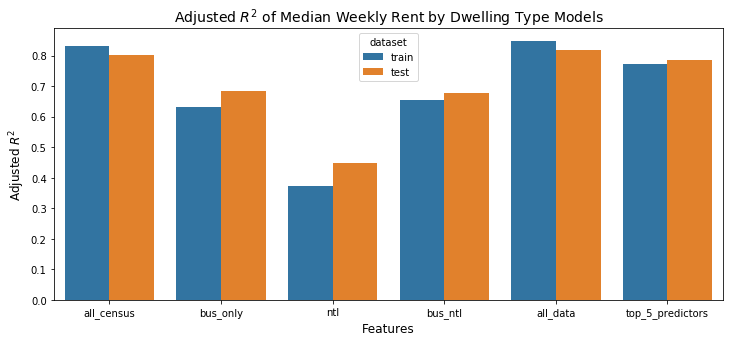

In [99]:
plt.figure(figsize = (12, 5))
ax = sns.barplot(x = 'variables', y = 'adj_r2', hue = 'dataset', data = rent_dwell_acc)
ax.set_xlabel('Features', fontsize = 12)
ax.set_ylabel('Adjusted $R^2$', fontsize = 12)
ax.set_title('Adjusted $R^2$ of Median Weekly Rent by Dwelling Type Models', size = 14)

Text(0.5, 1.0, 'Root Mean Squared Error of Median Weekly Rent by Dwelling Type Models')

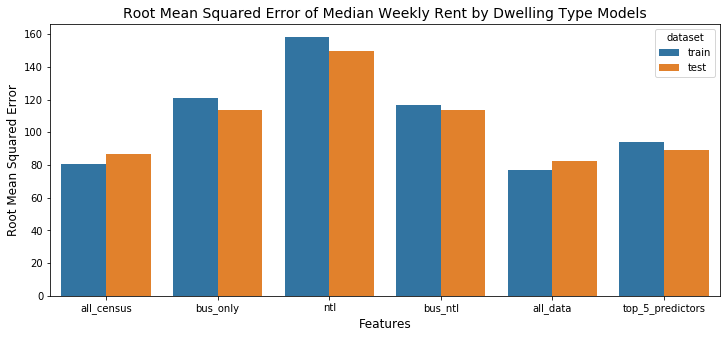

In [100]:
plt.figure(figsize = (12, 5))
ax = sns.barplot(x = 'variables', y = 'rmse', hue = 'dataset', data = rent_dwell_acc)
ax.set_xlabel('Features', fontsize = 12)
ax.set_ylabel('Root Mean Squared Error', fontsize = 12)
ax.set_title('Root Mean Squared Error of Median Weekly Rent by Dwelling Type Models', size = 14)

Text(0.5, 1.0, 'Mean Absolute Error of Median Weekly Rent by Dwelling Type Models')

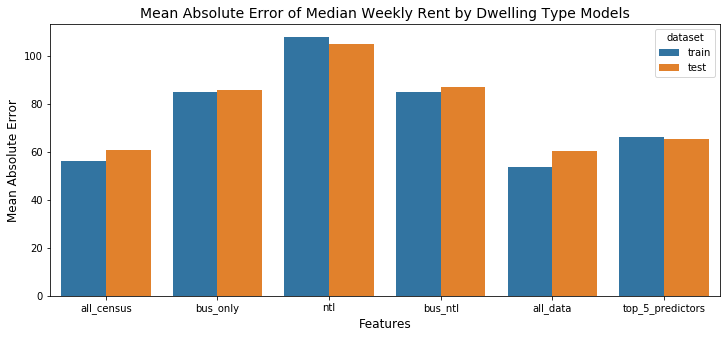

In [101]:
plt.figure(figsize = (12, 5))
ax = sns.barplot(x = 'variables', y = 'mae', hue = 'dataset', data = rent_dwell_acc)
ax.set_xlabel('Features', fontsize = 12)
ax.set_ylabel('Mean Absolute Error', fontsize = 12)
ax.set_title('Mean Absolute Error of Median Weekly Rent by Dwelling Type Models', size = 14)

### Conclusion
Based on the linear model regression runs for the three versions of the response variables, median weekly rent, median weekly rent by bedroom and median weekly rent by dwelling type, census features are the most powerful set of predictors relative to transportation and nighttime lights variables. This means that population characteristics of an LGA drive the weekly median price for the area with education ranked as the most important variable. However, when recursive feature elimination was performed on the models, the number of bus stops per land area also came up as one of the important variables predicting weekly median rent. This signifies that more accessibility can also drive higher rent in an LGA. Surprisingly, the number of train stations per land area did not have as high of an association to median weekly rent, which might be due to the small number of train stations relative to bus stops. Nighttime lights has the lowest predictive power with Adjusted $R^2$ close to 40% which is not a given that this dataset was produced from remote sensing machines. An obvious advantage of the nighttime lights and transportation stops is their availability. Nighttime lights are produced on a monthly basis with annual composites while bus stops are updated by the Transport for NSW in realtime.

The analysis has shown that while data sources collected using traditional methods (like surveys) shows great predictive power for median weekly rent, spatial and remote sensing data do a fairly good job in predicting the same variable. An extension of this analysis can be done by having postcodes of NSW as the unit of analysis. The census datapacks, including the shapefiles, are available up to postcode level, as well as the median weekly rent dataset. The nighttime lights data are available on a 500 meter by 500 meter grid so we can also compute the nightlights per postcode but we need to check if there are post codes that are less than 500 meter by 500 meter in area.